### Логистическая регрессия и случайный лес в задаче кредитного скоринга

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

In [10]:
# теорема Кондорсе «о жюри присяжных»
import numpy as np
10 * np.power(0.7, 3) * np.power(0.3, 2) + 5 * np.power(0.7, 4) * np.power(0.3, 1) + np.power(0.7, 5) 

0.8369199999999998

**Прогнозируемая переменная**
- SeriousDlqin2yrs – Человек не выплатил данный кредит в течение 90 дней; возможные значения 1/0

**Независимые признаки**
- age – Возраст заёмщика кредитных средств; тип - integer
- NumberOfTime30-59DaysPastDueNotWorse – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип - integer
- DebtRatio – Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.) / совокупный месячный доход percentage; тип - real
- MonthlyIncome – Месячный доход в долларах; тип - real
- NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип - integer
- NumberOfTime60-89DaysPastDueNotWorse – Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип - integer
- NumberOfDependents – Число человек в семье кредитозаёмщика; тип - integer

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [8]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [9]:
data = pd.read_csv('../data/credit_scoring_sample.csv', sep=';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [10]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

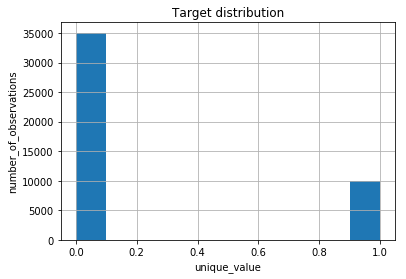

In [11]:
ax = data['SeriousDlqin2yrs'].hist()
ax.set_ylabel('number_of_observations')
ax.set_xlabel('unique_value')
ax.set_title('Target distribution')

data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [12]:
table = delete_nan(data)

In [13]:
X = table.iloc[:, 1:]
y = table.iloc[:, 0]

In [14]:
X.shape

(45063, 7)

### Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте np.random.seed(0), как это сделано в статье.

In [9]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
delay_credit_ages = table[table['SeriousDlqin2yrs'] == 1]['age'].values

In [11]:
np.random.seed(0)

# генерируем выборки с помощью бутстрэпа и сразу считаем по каждой из них среднее
delay_credit_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(delay_credit_ages, 1000)]

In [12]:
#  выводим интервальную оценку среднего
print('Ages of defaulters: mean interval', stat_intervals(delay_credit_mean_scores, 0.1))

Ages of defaulters: mean interval [45.71379414 46.12700479]


### Подбор параметров для модели логистической регрессии
#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [46]:
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки
lr = LogisticRegression(random_state=5, class_weight='balanced')

# параметр регуляризации
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.** Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [86]:
# train_test_share = 0.7
# X_train_len = round(X.shape[0] * train_test_share)
# y_train_len = round(y.shape[0] * train_test_share)
# X_train, X_test = X.iloc[: X_train_len, :], X.iloc[X_train_len :, :]
# y_train, y_test = y.iloc[: y_train_len], y.iloc[y_train_len :]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
gsv = GridSearchCV(estimator=lr, param_grid=parameters, cv=skf, verbose=1, scoring='roc_auc')
gsv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [48]:
gsv.best_params_, gsv.best_score_

({'C': 0.001}, 0.7975729314389011)

In [170]:
# # выход - в виде распределения
# y_prob = np.zeros((y_test.size, 2), dtype='float32')
# for i in range(0, y_test.size):
#     y_prob[i][y_test.values[i]] = 1.0

In [49]:
pred = gsv.predict(X_test)

from sklearn.metrics import accuracy_score
log_reg_acc = accuracy_score(y_test, pred)
log_reg_acc

0.8027293908798402

In [50]:
pred

array([0, 0, 0, ..., 1, 0, 1])

**Задание 4.** Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам пригодится для следующих заданий

In [173]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=lr, X=X_test, y=y_test, cv=5)

In [174]:
scores.std()

0.02969393928154399

In [175]:
scores

array([0.70011086, 0.73765946, 0.71420644, 0.78745838, 0.73529412])

### Определение влияния признаков

**Задание 5.** Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, чтобы можно их было корректно сравнить.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11584d828>,
      dtype=object)

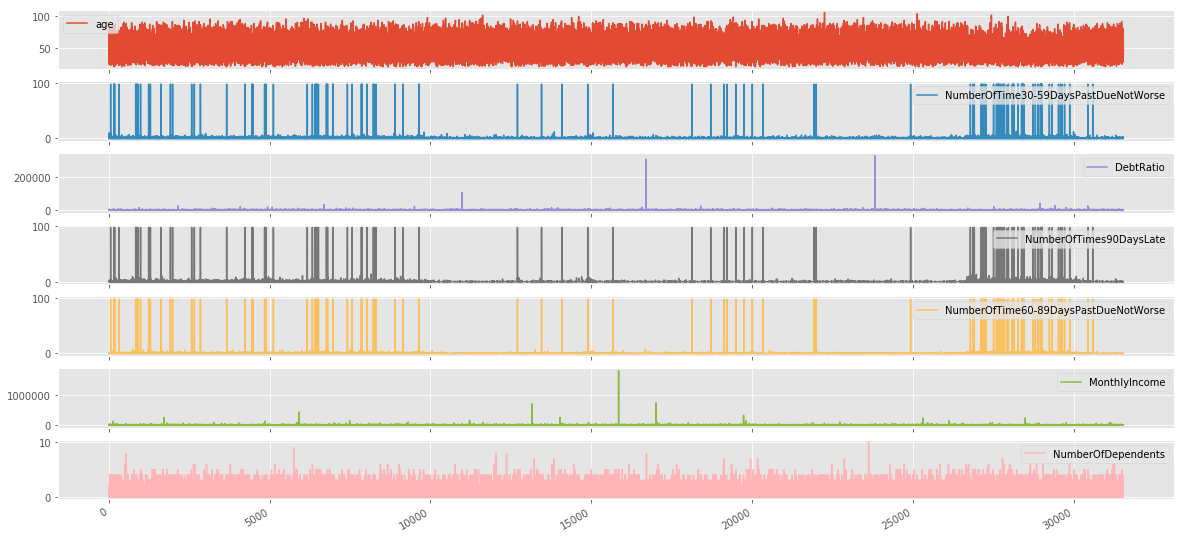

In [44]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 10
X_train.plot(subplots=True)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11830e7f0>,
      dtype=object)

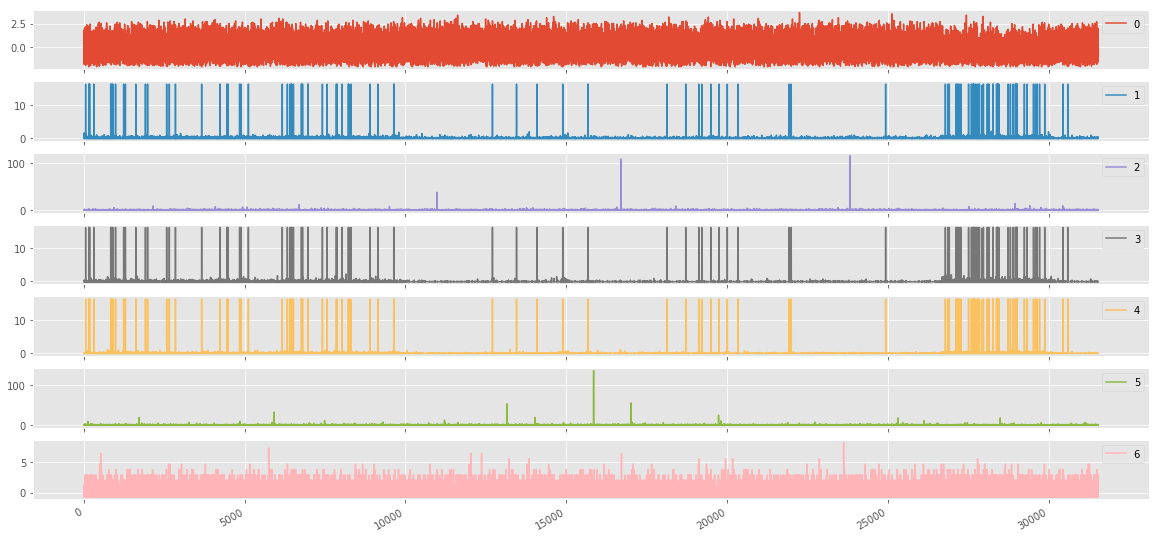

In [46]:
from pandas import DataFrame
df = DataFrame(data=scaled_X_train)
df.plot(subplots=True)

In [47]:
importances = gsv.best_estimator_.coef_

In [48]:
for f in range(7):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[0][f]))

1. age -0.016708 
2. NumberOfTime30-59DaysPastDueNotWorse 0.448125 
3. DebtRatio -0.000004 
4. NumberOfTimes90DaysLate 0.379710 
5. NumberOfTime60-89DaysPastDueNotWorse 0.045331 
6. MonthlyIncome -0.000007 
7. NumberOfDependents 0.117700 


In [73]:
gsv.best_estimator_.coef_[0]

array([-1.71697125e-02,  4.86120576e-01, -9.92018850e-06,  4.25751619e-01,
        7.67223597e-02, -1.10831359e-05,  1.20425084e-01])

In [75]:
np.sum(np.exp(gsv.best_estimator_.coef_[0]))

8.347410894882026

**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)

In [77]:
(np.exp(gsv.best_estimator_.coef_[0]) / np.sum(np.exp(gsv.best_estimator_.coef_[0])))[2]

0.1197964365781751

**Задание 7.** Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть __[здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)__)

In [80]:
lr_best_c = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr_best_c.fit(X, y)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [83]:
importances = lr_best_c.coef_

In [84]:
for f in range(7):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[0][f]))

1. age -0.018185 
2. NumberOfTime30-59DaysPastDueNotWorse 0.482349 
3. DebtRatio -0.000011 
4. NumberOfTimes90DaysLate 0.430314 
5. NumberOfTime60-89DaysPastDueNotWorse 0.065958 
6. MonthlyIncome -0.000011 
7. NumberOfDependents 0.115356 


In [94]:
np.exp(importances[0][0]*20)

0.6950957735889025

$\exp^{\beta\delta}$  – во столько раз больше шансы, что клиент не выплатит кредит. Где $\delta$ – на сколько делаем прирост. Например, если увеличить возраст на 20 лет, то шансы, что человек не выплатит кредит, увеличатся в 0.69.

### Случайный лес

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [22]:
rf_gsv = GridSearchCV(estimator=rf, param_grid=parameters, cv=skf, verbose=1, scoring='roc_auc')
rf_gsv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [23]:
rf_gsv.best_params_, rf_gsv.best_score_

({'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 7},
 0.8363253431105728)

In [24]:
rf_pred = rf_gsv.predict(X_test)

from sklearn.metrics import accuracy_score
rf_acc = accuracy_score(y_test, rf_pred)
rf_acc

0.805946965494286

In [25]:
rf_acc - log_reg_acc

0.0032175746144458284

**Задание 9.** Определите, какой признак имеет самое слабое влияние.

In [155]:
importances = rf_gsv.best_estimator_.feature_importances_
for f in range(7):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[f]))

1. age 0.114877 
2. NumberOfTime30-59DaysPastDueNotWorse 0.296675 
3. DebtRatio 0.082961 
4. NumberOfTimes90DaysLate 0.281302 
5. NumberOfTime60-89DaysPastDueNotWorse 0.146845 
6. MonthlyIncome 0.062013 
7. NumberOfDependents 0.015327 


### Бэггинг

In [53]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Также не забудьте передать параметр валидации cv и random_state=1. Какая лучшая точность получилась?

In [54]:
bagg_cl = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, 
                            random_state=42)

In [59]:
X_train.shape

(36050, 7)

In [55]:
rand_search_cv = RandomizedSearchCV(estimator=bagg_cl, param_distributions=parameters, 
                                    n_iter=20, cv=5, random_state=1, verbose=1)
rand_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 13.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start... n_estimators=100, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [56]:
rand_search_cv.best_params_, rand_search_cv.best_score_

({'max_samples': 0.5, 'max_features': 4, 'base_estimator__C': 10},
 0.78624133148405)

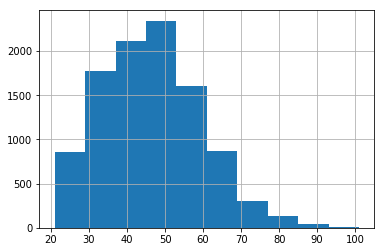

In [67]:
table[table['SeriousDlqin2yrs'] == 1]['age'].hist()